In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import LineCollection
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import fetch_olivetti_faces
from matplotlib import offsetbox
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')
customers.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [3]:
article_commande = pd.read_csv('olist_order_items_dataset.csv')
article_commande.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


In [4]:
paiements_commande = pd.read_csv('olist_order_payments_dataset.csv')
paiements_commande.head(1)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33


In [5]:
avis= pd.read_csv('olist_order_reviews_dataset.csv')
avis.head(1)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59


In [6]:
commande_init = pd.read_csv('olist_orders_dataset.csv')
commande_init.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [7]:
produit = pd.read_csv('olist_products_dataset.csv')
produit.head(1)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0


In [8]:
geo = pd.read_csv('olist_geolocation_dataset.csv')
geo.head(1)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP


In [9]:
vendeurs = pd.read_csv('olist_sellers_dataset.csv')
vendeurs.head(1)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP


In [10]:
categorie_produit = pd.read_csv('product_category_name_translation.csv')
categorie_produit.head(1)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty


## RFM:
La segmentation RFM ou méthode RFM est une méthode de segmentation principalement développée à l'origine pour les actions de marketing direct des véadistes et qui s'applique désormais également aux acteurs du e-commerce et du commerce traditionnel.

La segmentation RFM prend en compte la Récence (date de la dernière commande), la Fréquence des commandes et le Montant (de la dernière commande ou sur une période donnée) pour établir des segments de clients homogènes.

In [11]:
produit = pd.merge(produit, categorie_produit,
                    how="left",
                    on="product_category_name")

del_features_list = ["product_category_name", "product_weight_g",
                     "product_length_cm", "product_height_cm",
                     "product_width_cm"]
produit.drop(del_features_list, axis=1, inplace=True)
produit = produit.rename(columns={"product_category_name_english":
                                    "product_category_name"})

In [12]:
article_commande = pd.merge(article_commande, commande_init,
                       how="left",
                       on="order_id")

del_features_list = ["seller_id", "shipping_limit_date",
                     "order_approved_at",
                     "order_delivered_carrier_date",
                     "order_estimated_delivery_date"]
article_commande.drop(del_features_list,
                 axis=1,
                 inplace=True)

In [13]:
article_commande.groupby(by="order_status").sum()["order_item_id"]

order_status
approved            4
canceled          704
delivered      132036
invoiced          435
processing        455
shipped          1294
unavailable         8
Name: order_item_id, dtype: int64

In [14]:
article_commande = article_commande[article_commande["order_status"] == "delivered"]

In [15]:
article_commande = pd.merge(article_commande, customers,
                       how="left",
                       on="customer_id")
article_commande

,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110192,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-05-10 22:56:40,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA
110193,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-23 20:31:55,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR
110194,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-28 12:22:22,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP
110195,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-16 21:59:40,eb803377c9315b564bdedad672039306,13289,vinhedo,SP


In [16]:
data = pd.merge(article_commande, produit,
                how="left",
                on="product_id").merge(paiements_commande, 
                                       how="left",
                                       on="order_id").merge(avis, how="left",on="order_id")
data

,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48,871766c5855e863f6eccc05f988b23cb,...,1.0,credit_card,2.0,72.19,97ca439bc427b48bc1cd7177abe71365,5.0,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24,eb28e67c4c0b83846050ddfb8a35d051,...,1.0,credit_card,3.0,259.83,7b07bacd811c4117b742569b04ce3580,4.0,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16,3818d81c6709e39d06b2738a8d3a2474,...,1.0,credit_card,5.0,216.87,0c5b33dea94867d1ac402749e5438e8b,5.0,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39,af861d436cfc08b2c2ddefd0ba074622,...,1.0,credit_card,2.0,25.78,f4028d019cb58564807486a6aaf33817,4.0,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31,64b576fb70d441e8f1b2d7d446e483c5,...,1.0,credit_card,3.0,218.04,940144190dcba6351888cafa43f3a3a5,5.0,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115718,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-05-10 22:56:40,0c9aeda10a71f369396d0c04dce13a64,...,1.0,boleto,1.0,343.40,9185f849f32d82e216a4e025e0c50f5c,5.0,NaN,NaN,2018-05-11 00:00:00,2018-05-14 12:53:47
115719,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-23 20:31:55,0da9fe112eae0c74d3ba1fe16de0988b,...,1.0,boleto,1.0,386.53,be803f6a93d64719fd685c1cc610918a,5.0,NaN,NaN,2018-07-24 00:00:00,2018-07-25 09:25:29
115720,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-28 12:22:22,cd79b407828f02fdbba457111c38e4c4,...,1.0,credit_card,3.0,116.85,dbdd81cd59a1a9f94a10a990b4d48dce,5.0,NaN,NaN,2017-10-29 00:00:00,2017-10-29 21:33:52
115721,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-16 21:59:40,eb803377c9315b564bdedad672039306,...,1.0,credit_card,3.0,64.71,fba117c9ac40d41ca7be54741f471303,5.0,NaN,Recebi o produto antes do prazo e corretamente.,2017-08-17 00:00:00,2017-08-18 12:24:05


In [17]:
data.to_csv('simulation.csv', index=False)

In [18]:
dataagg = {
    "order_id": pd.Series.nunique,
    "order_purchase_timestamp": "max",
    "payment_installments": "max",
    "payment_value": "sum",
    "review_score": "mean",
    "payment_type": lambda x: x.mode().iloc[0] if not x.mode().empty else "Unknown",}

data = data.groupby("customer_unique_id").agg(dataagg).reset_index()

In [19]:
montant = data.groupby(by='order_id',as_index = False).sum()[['order_id','payment_value']].rename(columns={'payment_value':'Montant'})
montant

,order_id,Montant
0,1,18519593.06
1,2,1150319.49
2,3,138859.41
3,4,51950.64
4,5,7953.90
5,6,5939.65
6,7,4486.07
7,9,1963.58
8,15,879.27


In [20]:
frequence = pd.DataFrame(data['order_id'].value_counts(normalize=True)).reset_index(drop=False).rename(columns={'index':'order_id','order_id':'Frequence'})                                                                      
frequence

,order_id,Frequence
0,1,0.969997
1,2,0.027561
2,3,0.001939
3,4,0.000300
4,5,0.000096
5,6,0.000054
6,7,0.000032
7,9,0.000011
8,15,0.000011


In [21]:
frequency = pd.merge(frequence, data[["order_id", "order_purchase_timestamp"]], on="order_id")
frequency

,order_id,Frequence,order_purchase_timestamp
0,1,0.969997,2018-05-10 10:56:27
1,1,0.969997,2018-05-07 11:11:27
2,1,0.969997,2017-03-10 21:05:03
3,1,0.969997,2017-10-12 20:29:41
4,1,0.969997,2017-11-14 19:45:42
...,...,...,...
93353,7,0.000032,2018-02-14 13:22:12
93354,7,0.000032,2018-06-28 00:43:34
93355,7,0.000032,2018-06-01 11:38:29
93356,9,0.000011,2018-02-27 18:36:39


In [22]:
freq = frequency[frequency['Frequence'] > 0.03]
freq

,order_id,Frequence,order_purchase_timestamp
0,1,0.969997,2018-05-10 10:56:27
1,1,0.969997,2018-05-07 11:11:27
2,1,0.969997,2017-03-10 21:05:03
3,1,0.969997,2017-10-12 20:29:41
4,1,0.969997,2017-11-14 19:45:42
...,...,...,...
90552,1,0.969997,2017-06-08 21:00:36
90553,1,0.969997,2017-12-10 20:07:56
90554,1,0.969997,2017-02-07 15:49:16
90555,1,0.969997,2018-05-02 15:17:41


In [23]:
"""
clients = pd.DataFrame(freq['order_id'].value_counts())\
.reset_index(drop=False).rename(columns={'index':'order_id','order_id':'Frequence'})
"""

"\nclients = pd.DataFrame(freq['order_id'].value_counts()).reset_index(drop=False).rename(columns={'index':'order_id','order_id':'Frequence'})\n"

In [24]:
data.order_purchase_timestamp = pd.to_datetime(data["order_purchase_timestamp"])
data[["order_purchase_timestamp"]]

,order_purchase_timestamp
0,2018-05-10 10:56:27
1,2018-05-07 11:11:27
2,2017-03-10 21:05:03
3,2017-10-12 20:29:41
4,2017-11-14 19:45:42
...,...
93353,2017-06-08 21:00:36
93354,2017-12-10 20:07:56
93355,2017-02-07 15:49:16
93356,2018-05-02 15:17:41


In [25]:
# Calcul du nombre de jours depuis la commande
data['nombre_jour_depuis_commande'] = abs(data["order_purchase_timestamp"]-data["order_purchase_timestamp"].max()).dt.days

In [26]:
data[['Recence']] = data[['nombre_jour_depuis_commande']].rename(columns={'nombre_jour_depuis_commande':'Recence'})
data

,customer_unique_id,order_id,order_purchase_timestamp,payment_installments,payment_value,review_score,payment_type,nombre_jour_depuis_commande,Recence
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,8.0,141.90,5.0,credit_card,111,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,1.0,27.19,4.0,credit_card,114,114
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,8.0,86.22,3.0,credit_card,536,536
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,4.0,43.62,4.0,credit_card,320,320
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,6.0,196.89,5.0,credit_card,287,287
...,...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08 21:00:36,10.0,4134.84,5.0,credit_card,446,446
93354,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,1.0,84.58,4.0,credit_card,261,261
93355,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,1.0,112.46,5.0,credit_card,567,567
93356,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41,5.0,133.69,5.0,credit_card,118,118


In [27]:
data[['order_id','Recence']].groupby(by='order_id', as_index=False).min()

,order_id,Recence
0,1,0
1,2,0
2,3,1
3,4,7
4,5,13
5,6,6
6,7,62
7,9,182
8,15,8


In [28]:
df_recence = data[["Recence"]]

In [29]:
score = data.groupby(by='order_id',as_index = False).sum()[['order_id','review_score']].rename(columns={'review_score':'score'})

In [30]:
data

,customer_unique_id,order_id,order_purchase_timestamp,payment_installments,payment_value,review_score,payment_type,nombre_jour_depuis_commande,Recence
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,8.0,141.90,5.0,credit_card,111,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,1.0,27.19,4.0,credit_card,114,114
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,8.0,86.22,3.0,credit_card,536,536
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,4.0,43.62,4.0,credit_card,320,320
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,6.0,196.89,5.0,credit_card,287,287
...,...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08 21:00:36,10.0,4134.84,5.0,credit_card,446,446
93354,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,1.0,84.58,4.0,credit_card,261,261
93355,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,1.0,112.46,5.0,credit_card,567,567
93356,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41,5.0,133.69,5.0,credit_card,118,118


In [31]:
clients = data[['customer_unique_id',"Recence","order_id", "payment_value","review_score", "order_purchase_timestamp"]]

In [32]:
clients = clients.dropna()

In [33]:
clients = clients.reset_index(drop=True)
clients

,customer_unique_id,Recence,order_id,payment_value,review_score,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,5.0,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,536,1,86.22,3.0,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4.0,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,5.0,2017-11-14 19:45:42
...,...,...,...,...,...,...
92750,fffcf5a5ff07b0908bd4e2dbc735a684,446,1,4134.84,5.0,2017-06-08 21:00:36
92751,fffea47cd6d3cc0a88bd621562a9d061,261,1,84.58,4.0,2017-12-10 20:07:56
92752,ffff371b4d645b6ecea244b27531430a,567,1,112.46,5.0,2017-02-07 15:49:16
92753,ffff5962728ec6157033ef9805bacc48,118,1,133.69,5.0,2018-05-02 15:17:41


In [34]:
clients = clients.rename(columns={'order_id': 'Frequence', 'payment_value': 'Montant'})

In [35]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92755 entries, 0 to 92754
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        92755 non-null  object        
 1   Recence                   92755 non-null  int64         
 2   Frequence                 92755 non-null  int64         
 3   Montant                   92755 non-null  float64       
 4   review_score              92755 non-null  float64       
 5   order_purchase_timestamp  92755 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 4.2+ MB


In [36]:
clients.max()

customer_unique_id          ffffd2657e2aad2907e67c3e9daecbeb
Recence                                                  713
Frequence                                                 15
Montant                                            109312.64
review_score                                             5.0
order_purchase_timestamp                 2018-08-29 15:00:37
dtype: object

In [37]:
clients['Recence'] = clients['Recence'].astype(float)

In [38]:
clients.to_csv('clients.csv', index=False)

In [39]:
data.to_csv('simulation.csv', index=False)

In [40]:
clients_float = clients.select_dtypes(include = ['float']).columns
clients_float

Index(['Recence', 'Montant', 'review_score'], dtype='object')

In [41]:
# dataframe avec review_score
clients_flt = clients[['Frequence', 'Recence', 'Montant', 'review_score']]
clients_flt.reset_index(inplace=True, drop=True)

In [42]:
# dataframe sans review_score
client_rfm = clients[['Frequence', 'Recence', 'Montant']]
client_rfm.reset_index(inplace=True, drop=True)
client_rfm

,Frequence,Recence,Montant
0,1,111.0,141.90
1,1,114.0,27.19
2,1,536.0,86.22
3,1,320.0,43.62
4,1,287.0,196.89
...,...,...,...
92750,1,446.0,4134.84
92751,1,261.0,84.58
92752,1,567.0,112.46
92753,1,118.0,133.69


C:\Users\33641\.ipython\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\33641\.ipython\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\33641\.ipython\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

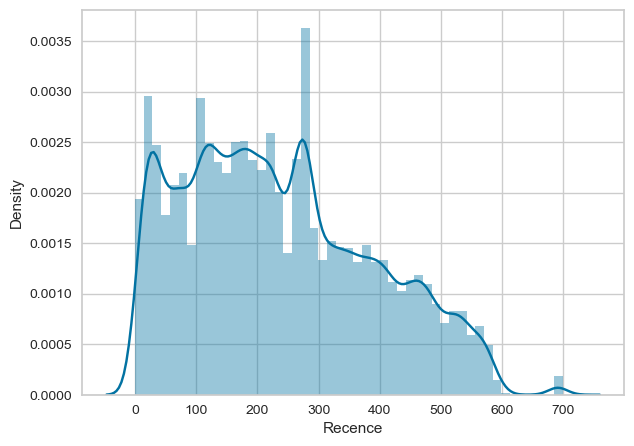

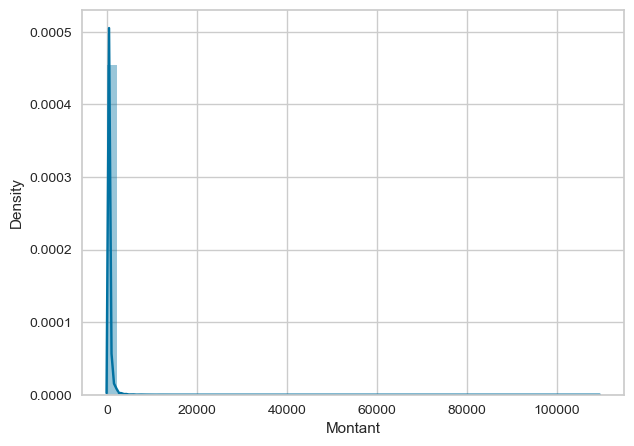

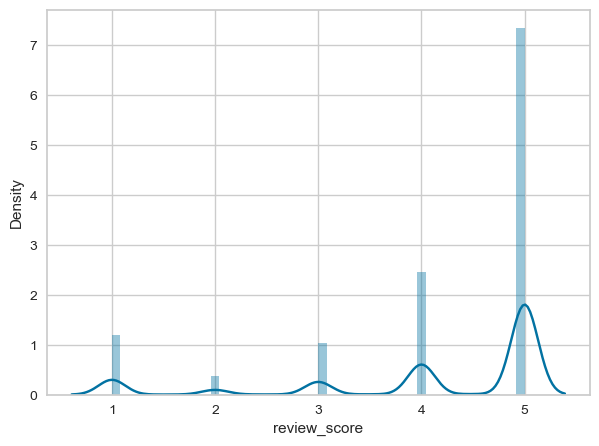

In [43]:
for col in clients.select_dtypes("float"):
    plt.figure(figsize=(7,5))
    sns.distplot(clients[col])

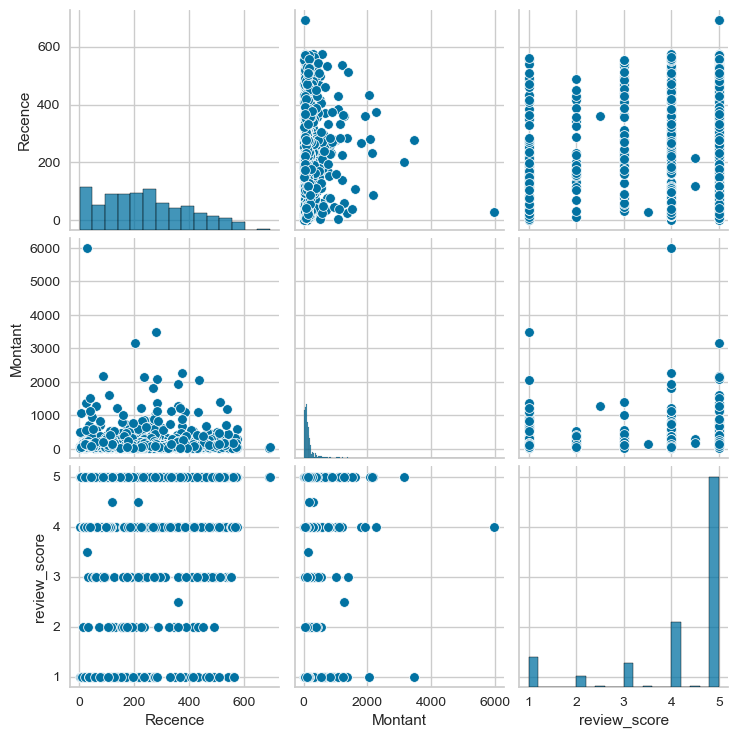

In [44]:
df_pairplot= clients.select_dtypes("float")

df_pairplot=df_pairplot.sample(frac=0.01)
sns.pairplot(data=df_pairplot)

In [45]:
clients.describe()

,Recence,Frequence,Montant,review_score
count,92755.000000,92755.000000,92755.000000,92755.000000
mean,236.777554,1.033540,212.157943,4.153363
std,152.598047,0.209543,630.025034,1.280573
min,0.000000,1.000000,0.000000,1.000000
25%,113.000000,1.000000,63.790000,4.000000
50%,218.000000,1.000000,113.050000,5.000000
75%,345.000000,1.000000,202.090000,5.000000
max,713.000000,15.000000,109312.640000,5.000000


<AxesSubplot:>

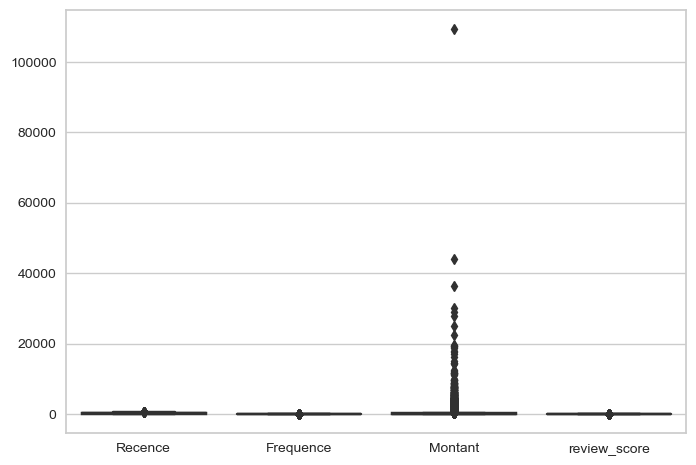

In [46]:
sns.boxplot(data=clients)

In [47]:
colors = ["red", "blue", "green", "yellow"]
#colormap =np.array(colors)

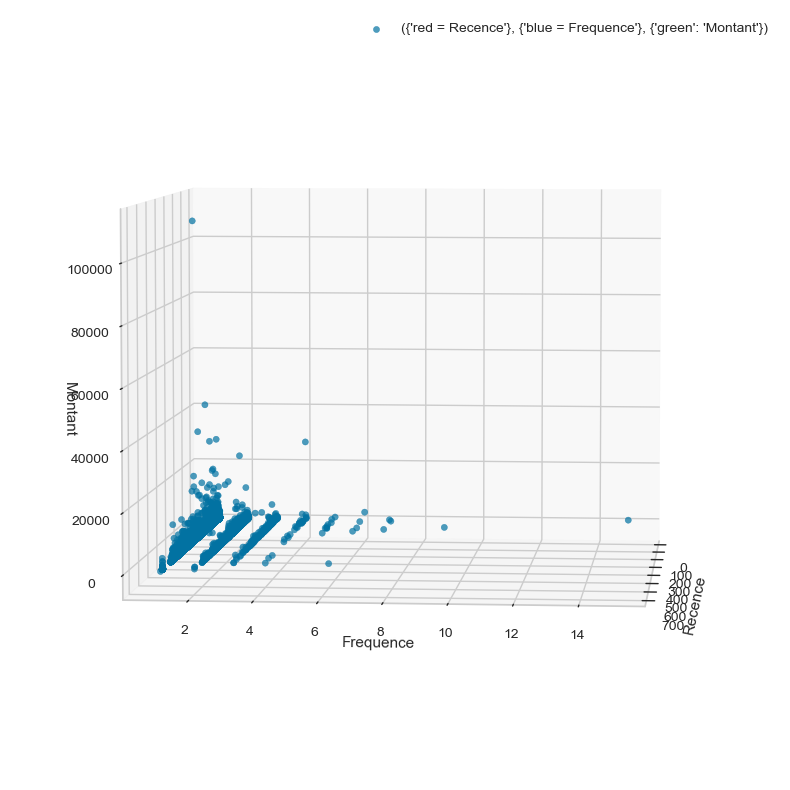

In [48]:
# pour n_clusters k=3

k = 3
kmeans = KMeans(n_clusters = k, random_state = 1).fit(clients_flt)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(clients_flt.Recence, clients_flt.Frequence, clients_flt.Montant, alpha=0.7)
plt.legend([({"red = Recence"}, {"blue = Frequence"}, {"green":"Montant"})])
ax.set_xlabel('Recence')
ax.set_ylabel('Frequence')
ax.set_zlabel('Montant')
ax.view_init(elev=5, azim=5)
plt.show()

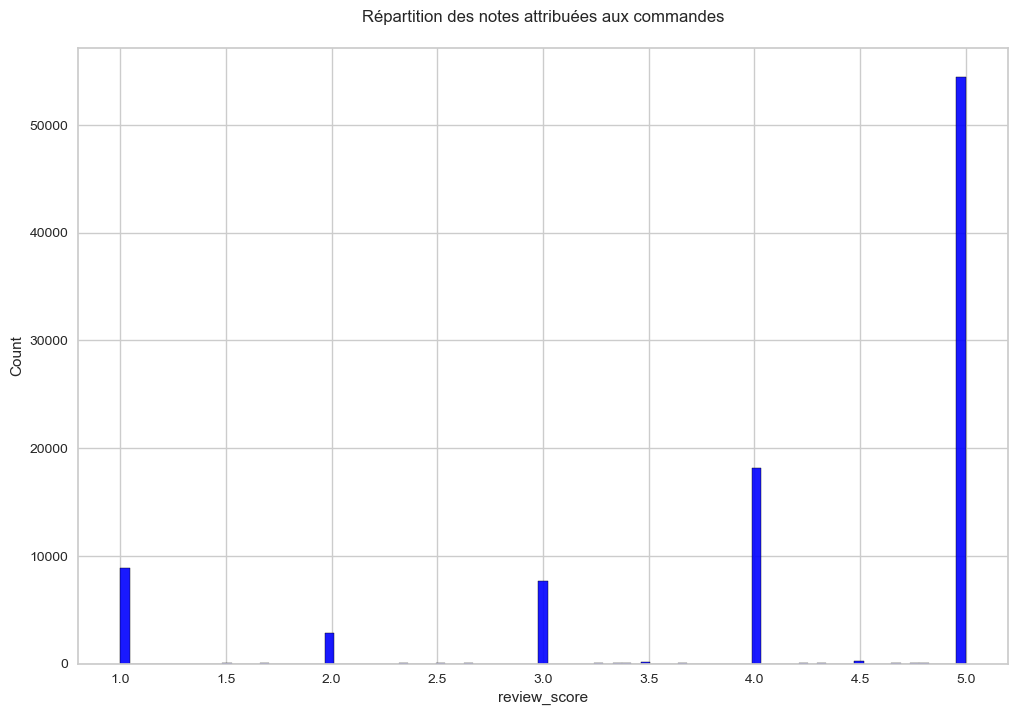

In [49]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data=clients, x="review_score", discrete=False,color="blue", alpha=0.9)
plt.title(f"Répartition des notes attribuées aux commandes\n",)
plt.show()

# ACP

In [50]:
clients_flt.head(1)

,Frequence,Recence,Montant,review_score
0,1,111.0,141.9,5.0


In [51]:
n_components = 4
pca = PCA(n_components=n_components)
pca= PCA(n_components=len(clients_flt.columns), svd_solver="full")

sc = StandardScaler()
X = sc.fit_transform(clients_flt.values)

pca.fit(X)
var_r = pca.explained_variance_ratio_
var_r

array([0.27586722, 0.25574858, 0.24585366, 0.22253054])

In [52]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([27.59, 25.57, 24.59, 22.25])

In [53]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="black",marker='o')
    plt.title("Plot d'éboulis")

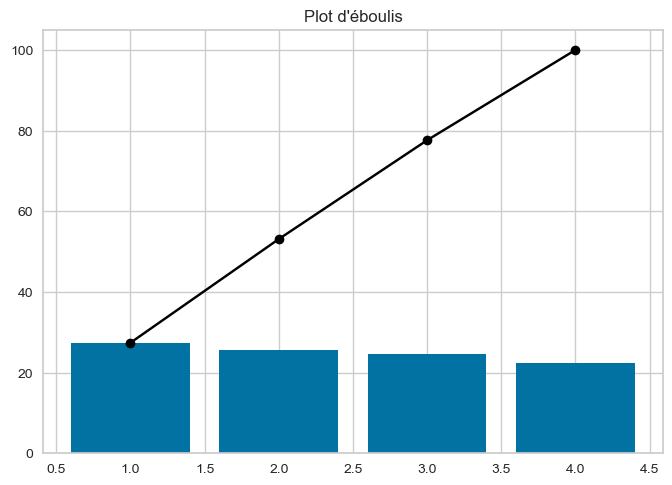

In [54]:
# choix du nombre de composantes à calculer
n_comp = 4

# selection des colonnes à prendre en compte dans l'ACP
df_acp = clients_flt.dropna(subset=['review_score'])
df_acp = df_acp[['Frequence','Recence','Montant', "review_score"]]
df_acp=df_acp.sample(frac=0.5)

# préparation des données pour l'ACP
X = df_acp.values
nutri = df_acp.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
acp = decomposition.PCA(n_components=n_comp)
acp.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(acp)

In [55]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 28.,  53.,  78., 100.])

In [56]:
pcs = pca.components_
pcs

array([[ 0.57741477, -0.12320439,  0.71057038, -0.38275656],
       [ 0.43012614, -0.61801337, -0.1069149 ,  0.64932286],
       [ 0.38964407,  0.77400574,  0.08270045,  0.49219228],
       [-0.57424836, -0.06160574,  0.69052123,  0.43545836]])

In [57]:
x_pca= acp.fit_transform(X_scaled)
df_pca_t= df_acp.copy()
pcols = ["F"+str(i) for i in range (1,x_pca.shape[1]+1)]
df_pca_t.loc[:,:] = x_pca
df_pca_t.columns = pcols
df_pca_t["review_score"]= clients_flt["review_score"]
df_pca_t

,F1,F2,F3,F4,review_score
55109,-0.386111,-0.036005,0.779326,0.390794,5.0
62816,-0.641494,-0.160391,0.965357,0.167316,5.0
30421,3.150692,2.295481,0.300408,-2.475225,3.4
35710,-0.583256,-0.175758,0.978466,0.223867,5.0
78843,-0.366309,0.497650,0.099517,0.341159,5.0
...,...,...,...,...,...
92368,-0.376839,0.921391,-0.437390,0.277138,5.0
66724,-0.253524,1.228359,-0.840737,0.353495,5.0
87723,-0.487081,0.264611,0.408710,0.257738,5.0
65116,0.102262,0.791770,-0.325487,0.742770,5.0


<AxesSubplot:xlabel='F1', ylabel='F2'>

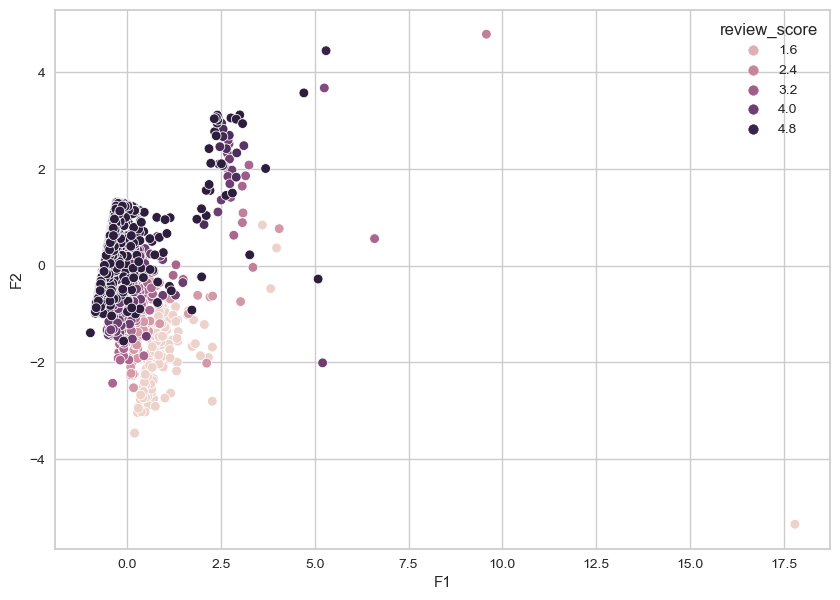

In [58]:
df_plot =df_pca_t.sample(frac=.05).sort_values("review_score")

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=df_plot, x="F1", y="F2", hue="review_score")

<AxesSubplot:xlabel='F1', ylabel='F3'>

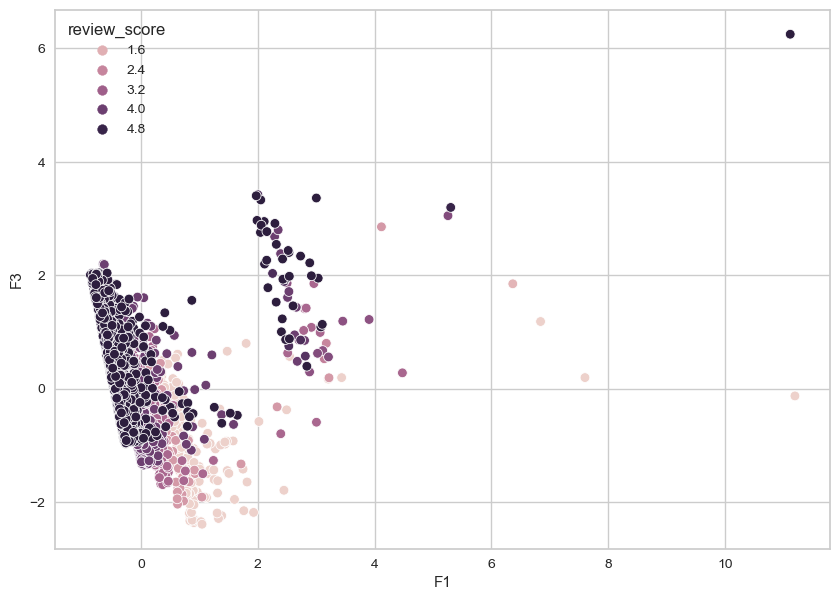

In [59]:
df_plot =df_pca_t.sample(frac=.05).sort_values("review_score")

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=df_plot, x="F1", y="F3", hue="review_score")

In [60]:
features = clients_flt.columns
features

Index(['Frequence', 'Recence', 'Montant', 'review_score'], dtype='object')

In [61]:
def correlation_graph(pca, x_y, features) : 
    """
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit 
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    """
   # Extrait x et y 
    x,y=x_y
   # Taille de l'image 
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, pca.components_[x, i], pca.components_[y, i], head_width=0.07, head_length=0.07, width=0.02)

        # Les labels
        plt.text(pca.components_[x, i] + 0.05, pca.components_[y, i] + 0.05, features[i])
        
    plt.plot([-1, 1], [0, 0], color='black', ls='--')
    plt.plot([0, 0], [-1, 1], color='black', ls='--')

    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))
    
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an)) 

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)


In [62]:
x_y = (0,1)
x_y

(0, 1)

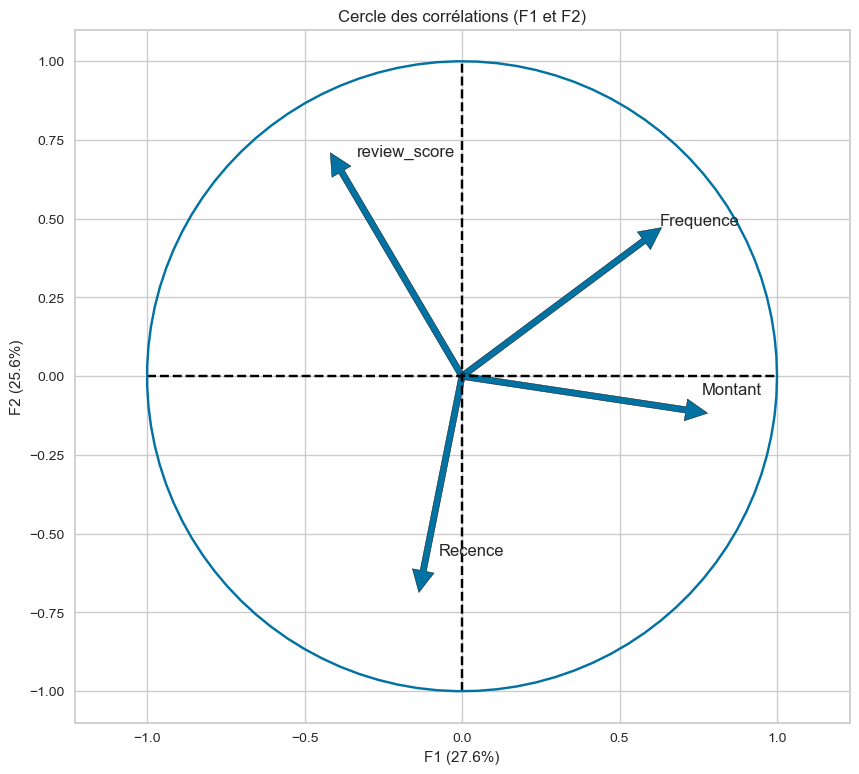

In [63]:
correlation_graph(pca, x_y, features)

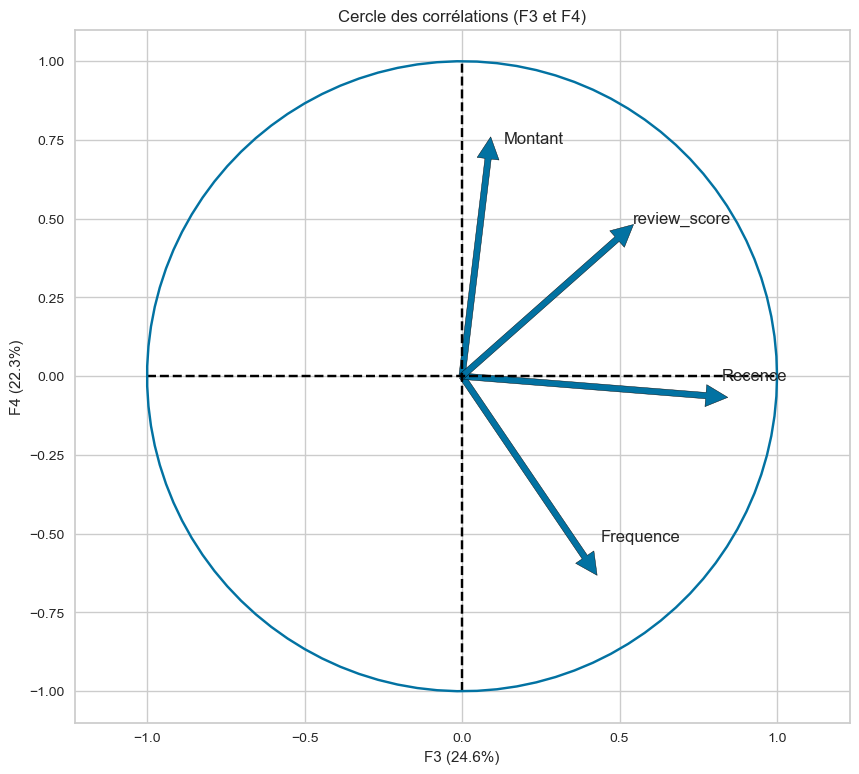

In [64]:
correlation_graph(pca, (2,3), features)

# t-SNE

In [65]:
clts = client_rfm.sample(frac = 0.10)

C:\Users\33641\.ipython\python\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\33641\.ipython\python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


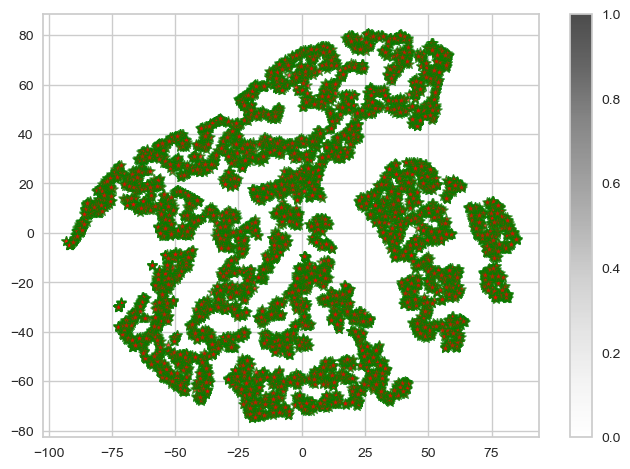

Wall time: 24 s


In [66]:
%%time
tsne = TSNE(n_components=2, perplexity = 35.0)

# Appliquer l'algorithme t-SNE aux données
X_tsne = tsne.fit_transform(clts)

# Afficher les résultats
plt.scatter(X_tsne[:,0], X_tsne[:,1], marker= "*", alpha=0.7, c='Red', edgecolor='green', linewidth=1)
plt.colorbar()
plt.show()